In [1]:
import itertools
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import sys, os, math
import pandas as pd
from sklearn import datasets, model_selection
from IPython import display

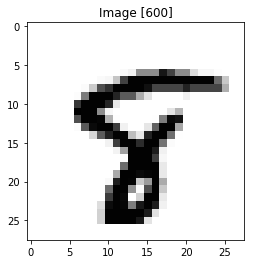

Label [600] =  8
(100, 1, 28, 28) (100,) 600


In [2]:
# Dataset
transform = transforms.Compose(  # list of transform objects
    [transforms.ToTensor(), transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]) 
train_dsets = dsets.MNIST('../data/mnist/', train=True, download=False, transform=transform)
batch_size = 100
train_loader = DataLoader(train_dsets, batch_size=batch_size, shuffle=True)

# train_loader shape check
for n, (image, label) in enumerate(train_loader):
    if n == len(train_loader)-1:
        plt.imshow(image[0,0], cmap='Greys')
        plt.title('Image [%d]' % (n+1))
        plt.show()
        print('Label [%d] = ' % (n+1), label[0].numpy())
        print(np.array(image).shape, np.array(label).shape, len(train_loader))

In [3]:
# Model - Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid())
        
    def forward(self, x):
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out

In [4]:
# Model - Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self. model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh())

    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.model(x)
        return out

In [5]:
# Model to Cuda
D = Discriminator().cuda()
G = Generator().cuda()

In [6]:
# Optimizer
criterion = nn.BCELoss()
D_optimizer = Adam(D.parameters(), lr=0.0002)
G_optimizer = Adam(G.parameters(), lr=0.0002)

In [7]:
# Train - D
def train_D(D, real_image, real_label, fake_image, fake_label):
    
    D.zero_grad()
    real_predict = D(real_image)
    real_loss = criterion(real_predict, real_label)
    
    fake_predict = D(fake_image)
    fake_loss = criterion(fake_predict, fake_label)
    
    D_loss = real_loss + fake_loss
    D_loss.backward()
    D_optimizer.step()
    
    return D_loss, real_loss, fake_loss

In [8]:
# Train - G
def train_G(G, fake_predict, real_label):
    
    G.zero_grad()
    G_loss = criterion(fake_predict, real_label)
    G_loss.backward()
    G_optimizer.step()
    
    return G_loss

In [9]:
# Random noise for test
n_test = 16
test_noise = Variable(torch.randn(n_test, 100).cuda())

Epoch [1/200], D_loss = 1.014, G_loss = 3.610


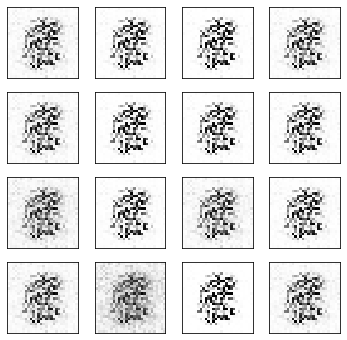

Epoch [50/200], D_loss = 1.086, G_loss = 1.213


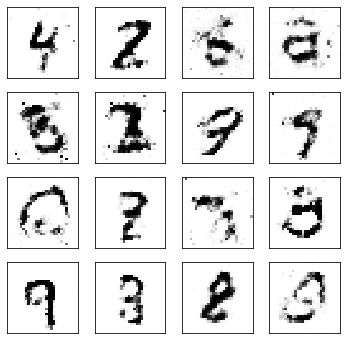

Epoch [100/200], D_loss = 1.212, G_loss = 0.962


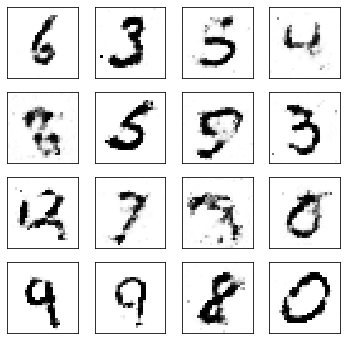

Epoch [150/200], D_loss = 1.190, G_loss = 0.885


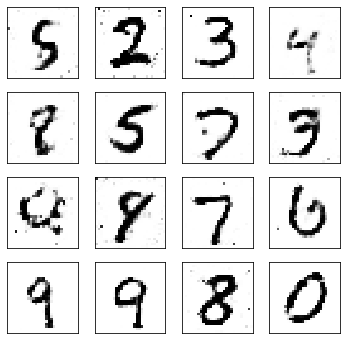

Epoch [200/200], D_loss = 1.310, G_loss = 0.935


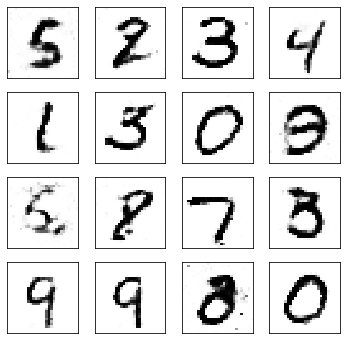

In [10]:
# image plot frame
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(6,6))
for i,j in itertools.product(range(ax.shape[0]), range(ax.shape[1])):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# Train start
epochs = 200

for epoch in range(epochs):
    for n, (real_image, _) in enumerate(train_loader):
        # real_image, real_label setting
        real_image = Variable(real_image.cuda())
        real_label = Variable(torch.ones(batch_size, 1).cuda())
        
        # noise for Discriminator training
        noise = Variable(torch.randn(batch_size, 100).cuda())
        fake_image = G(noise)
        fake_label = Variable(torch.zeros(batch_size, 1).cuda())
        
        # Discriminator training
        D_loss, real_loss, fake_loss = train_D(
            D, real_image, real_label, fake_image, fake_label)
        
        # noise for Generator training
        noise = Variable(torch.randn(batch_size, 100).cuda())
        fake_image = G(noise)
        fake_predict = D(fake_image)
        
        # Generator training
        G_loss = train_G(G, fake_predict, real_label)
    
    # test
    if epoch == 0 or (epoch+1) % 50 == 0:
        test_image = G(test_noise)
        for i in range(n_test):
            y = i // 4
            x = i % 4
            ax[y,x].cla()
            ax[y,x].imshow(test_image[i].data.cpu().reshape(28, 28), cmap='Greys')
        plt.savefig('../save/mnist/GAN_mnist_%03d.png' % (epoch+1))
        print('Epoch [%d/%d], D_loss = %.3f, G_loss = %.3f' % (epoch + 1, epochs, D_loss.item(), G_loss.item()))
        if epoch != epochs-1:
            display.display(plt.gcf())
  

In [11]:
torch.save(Generator().state_dict(), '../save/mnist/saved_generator.pt')
# saved_generator = torch.load('./save/mnist/saved_generator.pt')

In [ ]:
# Reference code
# https://github.com/prcastro/pytorch-gan/blob/master/MNIST%20GAN.ipynb